In [2]:
import torch
import os
import h5py
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from utils.PathDataset import Pathology_Dataset_test
from torch.utils.data import Dataset, DataLoader
from utils.T1Dataset import T1Dataset_regression_mr_path_test
from models.SENet import Model_path_mr
from lifelines.utils import concordance_index
from models.MLP import MLP
import torch
import torchtuples as tt
from utils.img_processing import convert_path,normalize_min_max
from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import matplotlib.pyplot as plt

In [3]:
csv_dir = [['G:/glioma/final_data/glioma_survive/only_mr/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/only_path/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/only_path/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_path/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology_post/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology_post/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology_post/result/ex_huashan.csv']]
save_dir = ['G:/glioma/final_data/glioma_survive/only_mr/result/',
            'G:/glioma/final_data/glioma_survive/only_path/result/',
            'G:/glioma/final_data/glioma_survive/mr_pathology/result/',
            'G:/glioma/final_data/glioma_survive/mr_pathology_post/result/']
df_TCGA_loc = pd.read_csv('G:/glioma/final_data/glioma_survive/mr_pathology/TCGA_function.csv')
df_huashan_loc = pd.read_csv('G:/glioma/final_data/glioma_survive/mr_pathology/huashan_function.csv')
# i = 0 仅核磁 i = 1 仅病理 i = 2 核磁 病理 pre i = 3 核磁 病理 post
i = 0
if i == 0:
    Model_name = "SE-DLFE-A"
elif i == 1:
    Model_name = "SE-DLFE-B"
elif i == 2:
    Model_name = "SE-DLFE"
else:
    Model_name = "SE-DLFE-AB"
df_train_ = pd.read_csv(csv_dir[i][0])
df_train, df_val, y_train, y_val = train_test_split(df_train_,df_train_['patient'].values,test_size=0.2,random_state=2022)
df_test = pd.read_csv(csv_dir[i][1])
df_ex_test = pd.read_csv(csv_dir[i][2])
# 训练集和验证集
df_train[['score','WHO','Age','Gender','IDH']] = df_train[['score','WHO','Age','Gender','IDH']].astype('float32')
get_target = lambda df_train: (df_train['survival_month'].values, df_train['status_dead'].values)
y_train = get_target(df_train)
train_feature = df_train[['score','WHO','Age','Gender','IDH']].values

df_val[['score','WHO','Age','Gender','IDH']] = df_val[['score','WHO','Age','Gender','IDH']].astype('float32')
val_feature = df_val[['score','WHO','Age','Gender','IDH']].values
get_target = lambda df_val: (df_val['survival_month'].values, df_val['status_dead'].values)
y_val = get_target(df_val)
val = tt.tuplefy(val_feature, y_val)
def calculate_param(df_TCGA_loc_M, model_cph1):
    df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']] = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']].astype('float32')
    feature_TCGA_loc_M = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']].values
    get_target = lambda df_TCGA_loc_M: (df_TCGA_loc_M['survival_month'].values, df_TCGA_loc_M['status_dead'].values)
    durations_test_ex, events_test_ex = get_target(df_TCGA_loc_M)
    _ = model_cph1.compute_baseline_hazards()
    surv = model_cph1.predict_surv_df(feature_TCGA_loc_M)
    ev = EvalSurv(surv, durations_test_ex, events_test_ex, censor_surv='km')
    time_grid = np.linspace(durations_test_ex.min(), durations_test_ex.max(), 100)
    return ev.concordance_td(),ev.integrated_brier_score(time_grid)

0:	[0s / 0s],		train_loss: 1.9690,	val_loss: 2.0074
1:	[0s / 0s],		train_loss: 1.8312,	val_loss: 1.8834
2:	[0s / 0s],		train_loss: 1.7169,	val_loss: 1.8313
3:	[0s / 0s],		train_loss: 1.6733,	val_loss: 1.6558
4:	[0s / 0s],		train_loss: 1.7042,	val_loss: 1.6066
5:	[0s / 0s],		train_loss: 1.6697,	val_loss: 1.6777
6:	[0s / 0s],		train_loss: 1.5872,	val_loss: 1.5664
7:	[0s / 0s],		train_loss: 1.5247,	val_loss: 1.5022
8:	[0s / 0s],		train_loss: 1.5418,	val_loss: 1.5013
9:	[0s / 0s],		train_loss: 1.4291,	val_loss: 1.6373
10:	[0s / 0s],		train_loss: 1.4515,	val_loss: 1.5186
11:	[0s / 0s],		train_loss: 1.4608,	val_loss: 1.4811
12:	[0s / 0s],		train_loss: 1.4265,	val_loss: 1.4825
13:	[0s / 0s],		train_loss: 1.2963,	val_loss: 1.6285
14:	[0s / 0s],		train_loss: 1.5994,	val_loss: 1.6258
15:	[0s / 0s],		train_loss: 1.4542,	val_loss: 1.4901
16:	[0s / 0s],		train_loss: 1.3552,	val_loss: 1.4099
17:	[0s / 0s],		train_loss: 1.2727,	val_loss: 1.4533
18:	[0s / 0s],		train_loss: 1.2321,	val_loss: 1.4243
19:

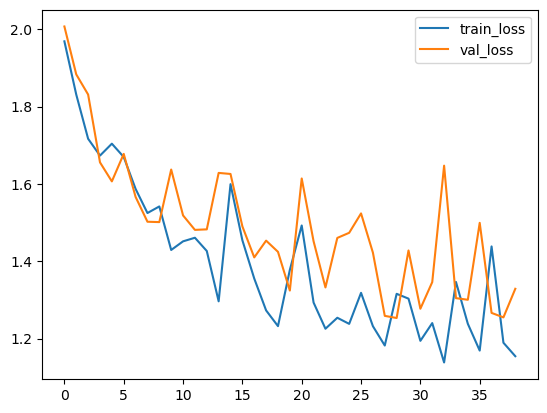

In [69]:
in_features = train_feature.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
model_cph = CoxPH(net, tt.optim.Adam)
batch_size = 20
lrfinder = model_cph.lr_finder(train_feature, y_train, batch_size, tolerance=10)
# _ = lrfinder.plot()
model_cph.optimizer.set_lr(lrfinder.get_best_lr())
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model_cph.fit(train_feature, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)
_ = log.plot()


In [70]:
print(Model_name)
df_test[['score','WHO','Age','Gender','IDH']] = df_test[['score','WHO','Age','Gender','IDH']].astype('float32')
test_feature = df_test[['score','WHO','Age','Gender','IDH']].values
get_target = lambda df_test: (df_test['survival_month'].values, df_test['status_dead'].values)
y_test = get_target(df_test)
test = tt.tuplefy(test_feature, y_test)
durations_test, events_test = get_target(df_test)
_ = model_cph.compute_baseline_hazards()
surv = model_cph.predict_surv_df(test_feature)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print("TCGA-Test-Set")
print("c-index",ev.concordance_td())
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
print("brier_score",ev.integrated_brier_score(time_grid))

df_ex_test[['score','WHO','Age','Gender','IDH']] = df_ex_test[['score','WHO','Age','Gender','IDH']].astype('float32')
test_ex_feature = df_ex_test[['score','WHO','Age','Gender','IDH']].values
get_target = lambda df_ex_test: (df_ex_test['survival_month'].values, df_ex_test['status_dead'].values)
y_ex_test = get_target(df_ex_test)
test_ex = tt.tuplefy(test_ex_feature, y_ex_test)
durations_test_ex, events_test_ex = get_target(df_ex_test)
_ = model_cph.compute_baseline_hazards()
surv = model_cph.predict_surv_df(test_ex_feature)
ev = EvalSurv(surv, durations_test_ex, events_test_ex, censor_surv='km')
print("Huashan-Test-Set")
print("c-index",ev.concordance_td())
time_grid = np.linspace(durations_test_ex.min(), durations_test_ex.max(), 100)
print("brier_score",ev.integrated_brier_score(time_grid))

SE-DLFE-AB
TCGA-Test-Set
c-index 0.8852459016393442
brier_score 0.14210390409241153
Huashan-Test-Set
c-index 0.771712158808933
brier_score 0.14822345860619315


G:/glioma/final_data/glioma_survive/mr_pathology_post/result/SE-DLFE-AB.pth


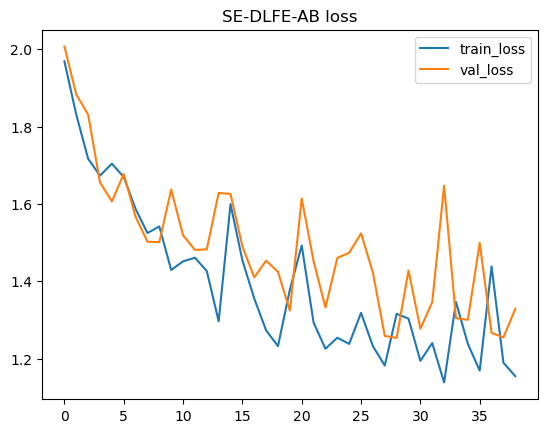

In [71]:
model_cph.save_net(os.path.join(save_dir[i],Model_name+'.pth'))
_ = log.plot()
plt.title(Model_name + " loss")
plt.savefig(os.path.join(save_dir[i],Model_name+' Loss.png'),dpi = 500, bbox_inches="tight")

print(os.path.join(save_dir[i],Model_name+'.pth'))
# model_cph.load_net(os.path.join(save_dir[i],'SE-DLFE-A.pth'))

In [56]:
#  不训练
csv_dir = [['G:/glioma/final_data/glioma_survive/only_mr/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_mr/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/only_path/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/only_path/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/only_path/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology/result/ex_huashan.csv'],
           ['G:/glioma/final_data/glioma_survive/mr_pathology_post/result/train_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology_post/result/test_TCGA.csv','G:/glioma/final_data/glioma_survive/mr_pathology_post/result/ex_huashan.csv']]
save_dir = ['G:/glioma/final_data/glioma_survive/only_mr/result/',
            'G:/glioma/final_data/glioma_survive/only_path/result/',
            'G:/glioma/final_data/glioma_survive/mr_pathology/result/',
            'G:/glioma/final_data/glioma_survive/mr_pathology_post/result/']
# i = 0 仅核磁 i = 1 仅病理 i = 2 核磁 病理 pre i = 3 核磁 病理 post
i = 2
if i == 0:
    Model_name = "SE-DLFE-A"
elif i == 1:
    Model_name = "SE-DLFE-B"
elif i == 2:
    Model_name = "SE-DLFE"
else:
    Model_name = "SE-DLFE-AB"
df_train_ = pd.read_csv(csv_dir[i][0])
df_train, df_val, y_train, y_val = train_test_split(df_train_,df_train_['patient'].values,test_size=0.2,random_state=2022)
df_test = pd.read_csv(csv_dir[i][1])
df_ex_test = pd.read_csv(csv_dir[i][2])
# 训练集和验证集
df_train[['score','WHO','Age','Gender','IDH']] = df_train[['score','WHO','Age','Gender','IDH']].astype('float32')
get_target = lambda df_train: (df_train['survival_month'].values, df_train['status_dead'].values)
y_train = get_target(df_train)
train_feature = df_train[['score','WHO','Age','Gender','IDH']].values

df_val[['score','WHO','Age','Gender','IDH']] = df_val[['score','WHO','Age','Gender','IDH']].astype('float32')
val_feature = df_val[['score','WHO','Age','Gender','IDH']].values
get_target = lambda df_val: (df_val['survival_month'].values, df_val['status_dead'].values)
y_val = get_target(df_val)
val = tt.tuplefy(val_feature, y_val)
def calculate_param(df_TCGA_loc_M, model_cph1):
    df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']] = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']].astype('float32')
    feature_TCGA_loc_M = df_TCGA_loc_M[['score','WHO','Age','Gender','IDH']].values
    get_target = lambda df_TCGA_loc_M: (df_TCGA_loc_M['survival_month'].values, df_TCGA_loc_M['status_dead'].values)
    durations_test_ex, events_test_ex = get_target(df_TCGA_loc_M)
    _ = model_cph1.compute_baseline_hazards()
    surv = model_cph1.predict_surv_df(feature_TCGA_loc_M)
    ev = EvalSurv(surv, durations_test_ex, events_test_ex, censor_surv='km')
    time_grid = np.linspace(durations_test_ex.min(), durations_test_ex.max(), 100)
    return ev.concordance_td(),ev.integrated_brier_score(time_grid)

in_features = train_feature.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False
batch_size = 20
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)
model_cph1 = CoxPH(net, tt.optim.Adam)
epochs = 1000
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = model_cph1.fit(train_feature, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

model_cph1.load_net(os.path.join(save_dir[i],Model_name+'.pth'))


0:	[0s / 0s],		train_loss: 2.4920,	val_loss: 2.6799
1:	[0s / 0s],		train_loss: 2.2123,	val_loss: 2.2647
2:	[0s / 0s],		train_loss: 2.0281,	val_loss: 2.0128
3:	[0s / 0s],		train_loss: 1.9312,	val_loss: 1.8555
4:	[0s / 0s],		train_loss: 1.9382,	val_loss: 1.7820
5:	[0s / 0s],		train_loss: 1.8361,	val_loss: 1.7243
6:	[0s / 0s],		train_loss: 1.8558,	val_loss: 1.6789
7:	[0s / 0s],		train_loss: 1.8398,	val_loss: 1.6447
8:	[0s / 0s],		train_loss: 1.8436,	val_loss: 1.6084
9:	[0s / 0s],		train_loss: 1.7026,	val_loss: 1.5942
10:	[0s / 0s],		train_loss: 1.6773,	val_loss: 1.5681
11:	[0s / 0s],		train_loss: 1.7089,	val_loss: 1.5356
12:	[0s / 0s],		train_loss: 1.7043,	val_loss: 1.5208
13:	[0s / 0s],		train_loss: 1.6469,	val_loss: 1.5273
14:	[0s / 0s],		train_loss: 1.6608,	val_loss: 1.5224
15:	[0s / 0s],		train_loss: 1.5734,	val_loss: 1.5201
16:	[0s / 0s],		train_loss: 1.5829,	val_loss: 1.4732
17:	[0s / 0s],		train_loss: 1.6491,	val_loss: 1.4591
18:	[0s / 0s],		train_loss: 1.4905,	val_loss: 1.4631
19:

In [57]:
print("TCGA-Test-Set (c-index, brier scores)",calculate_param(df_test,model_cph1))
print("Huashan-Test-Set (c-index, brier scores)",calculate_param(df_ex_test,model_cph1))

TCGA-Test-Set (c-index, brier scores) (0.9289617486338798, 0.059483649902407815)
Huashan-Test-Set (c-index, brier scores) (0.8002481389578163, 0.1643554165958001)


In [58]:
# 功能分区
print(Model_name)
df_TCGA_loc = pd.read_csv('G:/glioma/final_data/glioma_survive/mr_pathology/TCGA_function.csv')
df_huashan_loc = pd.read_csv('G:/glioma/final_data/glioma_survive/mr_pathology/huashan_function.csv')
df_TCGA_loc = pd.merge(df_test,df_TCGA_loc,how='inner')
df_TCGA_loc_M_and_L = df_TCGA_loc[(df_TCGA_loc['function_location'] != 0)]
# df_TCGA_loc_L 4个    df_TCGA_loc_M 7个
df_TCGA_loc_M_and_L = pd.DataFrame(df_TCGA_loc_M_and_L)
df_TCGA_loc_no = df_TCGA_loc[(df_TCGA_loc['function_location'] == 0)]
df_TCGA_loc_no = pd.DataFrame(df_TCGA_loc_no)
df_huashan_loc = pd.merge(df_ex_test,df_huashan_loc,how='inner')
df_huashan_loc_M_and_L = df_huashan_loc[(df_huashan_loc['function_location'] != 0)]
df_huashan_loc_no = df_huashan_loc[(df_huashan_loc['function_location'] == 0)]
df_huashan_loc_no = pd.DataFrame(df_huashan_loc_no)
df_huashan_loc_M_and_L = pd.DataFrame(df_huashan_loc_M_and_L)
df_TCGA_loc_M_and_L.to_csv(os.path.join(save_dir[i],'TCGA_func_test.csv'),index=False)
df_TCGA_loc_no.to_csv(os.path.join(save_dir[i],'TCGA_without_func_test.csv'),index=False)
df_huashan_loc_M_and_L.to_csv(os.path.join(save_dir[i],'huashan_func_test.csv'),index=False)
df_huashan_loc_no.to_csv(os.path.join(save_dir[i],'huashan_without_func_test.csv'),index=False)
print("TCGA-功能区 (c-index, brier scores)",calculate_param(df_TCGA_loc_M_and_L,model_cph1))
print("TCGA-非功能区 (c-index, brier scores)",calculate_param(df_TCGA_loc_no,model_cph1))
print("Huashan-功能区 (c-index, brier scores)",calculate_param(df_huashan_loc_M_and_L,model_cph1))
print("Huashan-非功能区 (c-index, brier scores)",calculate_param(df_huashan_loc_no,model_cph1))

df_loc_all = pd.concat([df_TCGA_loc,df_huashan_loc])
df_loc_all_M = df_loc_all[(df_loc_all['function_location'] == 1) | (df_loc_all['function_location'] == 3)]
df_loc_all_M = pd.DataFrame(df_loc_all_M)
df_loc_all_L = df_loc_all[(df_loc_all['function_location'] == 2) | (df_loc_all['function_location'] == 3)]
df_loc_all_L = pd.DataFrame(df_loc_all_L)
df_loc_all_no = df_loc_all[(df_loc_all['function_location'] == 0)]
df_loc_all_no = pd.DataFrame(df_loc_all_no)
print("语言功能区 (c-index, brier scores)",calculate_param(df_loc_all_L,model_cph1))
print("运动功能区 (c-index, brier scores)",calculate_param(df_loc_all_M,model_cph1))
print("其他功能区(c-index, brier scores)",calculate_param(df_loc_all_no,model_cph1))

df_TCGA_loc_M_and_L.to_csv(os.path.join(save_dir[i],'TCGA_func_test.csv'),index=False)
df_TCGA_loc_no.to_csv(os.path.join(save_dir[i],'TCGA_without_func_test.csv'),index=False)
df_huashan_loc_M_and_L.to_csv(os.path.join(save_dir[i],'huashan_func_test.csv'),index=False)
df_huashan_loc_no.to_csv(os.path.join(save_dir[i],'huashan_without_func_test.csv'),index=False)
df_loc_all_M.to_csv(os.path.join(save_dir[i],'All_Motion_test.csv'),index=False)
df_loc_all_L.to_csv(os.path.join(save_dir[i],'All_Language_test.csv'),index=False)
df_loc_all_no.to_csv(os.path.join(save_dir[i],'All_without_func_test.csv'),index=False)

SE-DLFE
TCGA-功能区 (c-index, brier scores) (0.8571428571428571, 0.10820274903968248)
TCGA-非功能区 (c-index, brier scores) (0.9545454545454546, 0.03370518095739935)
Huashan-功能区 (c-index, brier scores) (0.8666666666666667, 0.08988288297215595)
Huashan-非功能区 (c-index, brier scores) (0.7615384615384615, 0.21171184009665234)
语言功能区 (c-index, brier scores) (0.8604651162790697, 0.0942107511443755)
运动功能区 (c-index, brier scores) (0.8416666666666667, 0.13302020539886572)
其他功能区(c-index, brier scores) (0.855072463768116, 0.09096197685003116)


In [59]:
# WHO分区
print(Model_name)
df_TCGA_gbm = df_test[(df_test['WHO'] == 4)]
df_TCGA_gbm = pd.DataFrame(df_TCGA_gbm)
df_TCGA_lgg = df_test[(df_test['WHO'] != 4)]
df_TCGA_lgg = pd.DataFrame(df_TCGA_lgg)

df_huashan_gbm = df_ex_test[(df_ex_test['WHO'] == 4)]
df_huashan_lgg = df_ex_test[(df_ex_test['WHO'] != 4)]
df_huashan_gbm = pd.DataFrame(df_huashan_gbm)
df_huashan_lgg = pd.DataFrame(df_huashan_lgg)
df_TCGA_gbm.to_csv(os.path.join(save_dir[i],'TCGA_gbm_test.csv'),index=False)
df_TCGA_lgg.to_csv(os.path.join(save_dir[i],'TCGA_lgg_test.csv'),index=False)
df_huashan_gbm.to_csv(os.path.join(save_dir[i],'huashan_gbm_test.csv'),index=False)
df_huashan_lgg.to_csv(os.path.join(save_dir[i],'huashan_lgg_test.csv'),index=False)
print("TCGA-GBM (c-index, brier scores)",calculate_param(df_TCGA_gbm,model_cph1))
print("TCGA-LGG (c-index, brier scores)",calculate_param(df_TCGA_lgg,model_cph1))
print("Huashan-GBM (c-index, brier scores)",calculate_param(df_huashan_gbm,model_cph1))
print("Huashan-LGG (c-index, brier scores)",calculate_param(df_huashan_lgg,model_cph1))

df_TCGA_gbm.to_csv(os.path.join(save_dir[i],'TCGA_GBM_test.csv'),index = False)
df_TCGA_lgg.to_csv(os.path.join(save_dir[i],'TCGA_LGG_test.csv'),index = False)
df_huashan_gbm.to_csv(os.path.join(save_dir[i],'huashan_GBM_test.csv'),index = False)
df_huashan_lgg.to_csv(os.path.join(save_dir[i],'huashan_LGG_test.csv'),index = False)

SE-DLFE
TCGA-GBM (c-index, brier scores) (0.8611111111111112, 0.061684405877566045)
TCGA-LGG (c-index, brier scores) (0.9529411764705882, 0.08047156646594883)
Huashan-GBM (c-index, brier scores) (0.6925675675675675, 0.19173496909693483)
Huashan-LGG (c-index, brier scores) (0.7142857142857143, 0.18864779922926098)
